In [48]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Pablo.Agent import Dueling_DDQN_Agent
from Agents.Tapas_en_Mallorca.Agent import Combined_Agent

from importlib import reload

In [49]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [50]:
reload(h_env)
env_name = "../weights/prio_agent_self_play_17_2_25"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

"""agent = Dueling_DDQN_Agent(
    state_space,
    action_space,
    env = env,
    seed = seed,
    use_eps_decay = False,
    use_dueling = True,
    use_double = True,
    use_noisy = True,
    hidden_sizes = [256, 256]
)"""

agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name = "episode_5000" )

INFO:root:Using device: cuda


Network loaded from ../weights/prio_agent_self_play_17_2_25/weights/episode_5000.pth


In [51]:
stats, losses = sf.load_stats(env_name)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/returns_plot.png


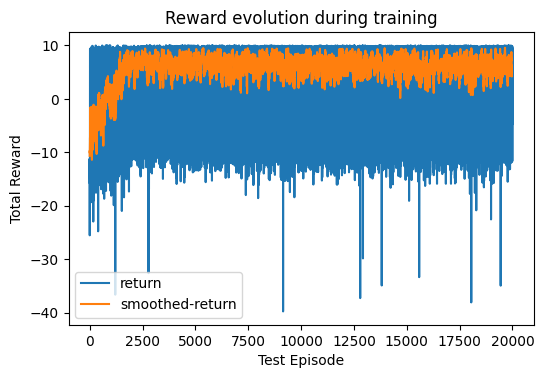

In [52]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/losses_plot.png


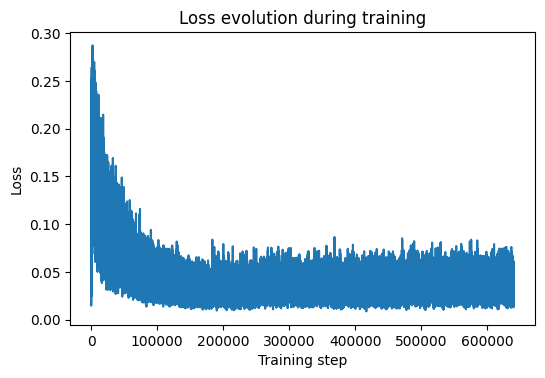

In [53]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/beta_evolution.png


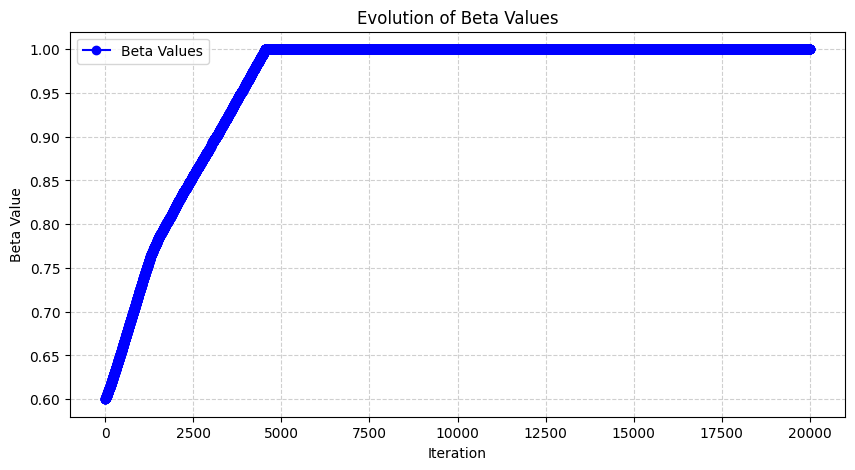

In [54]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/epsilon_evolution.png


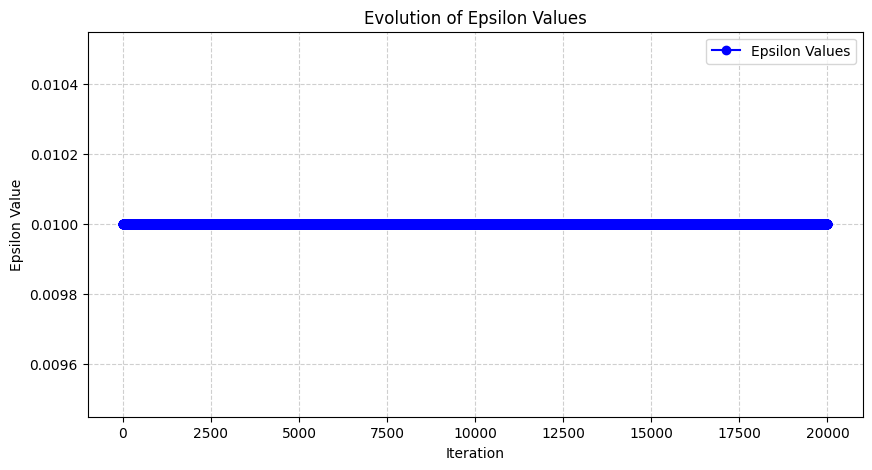

In [55]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/match_evolution.png


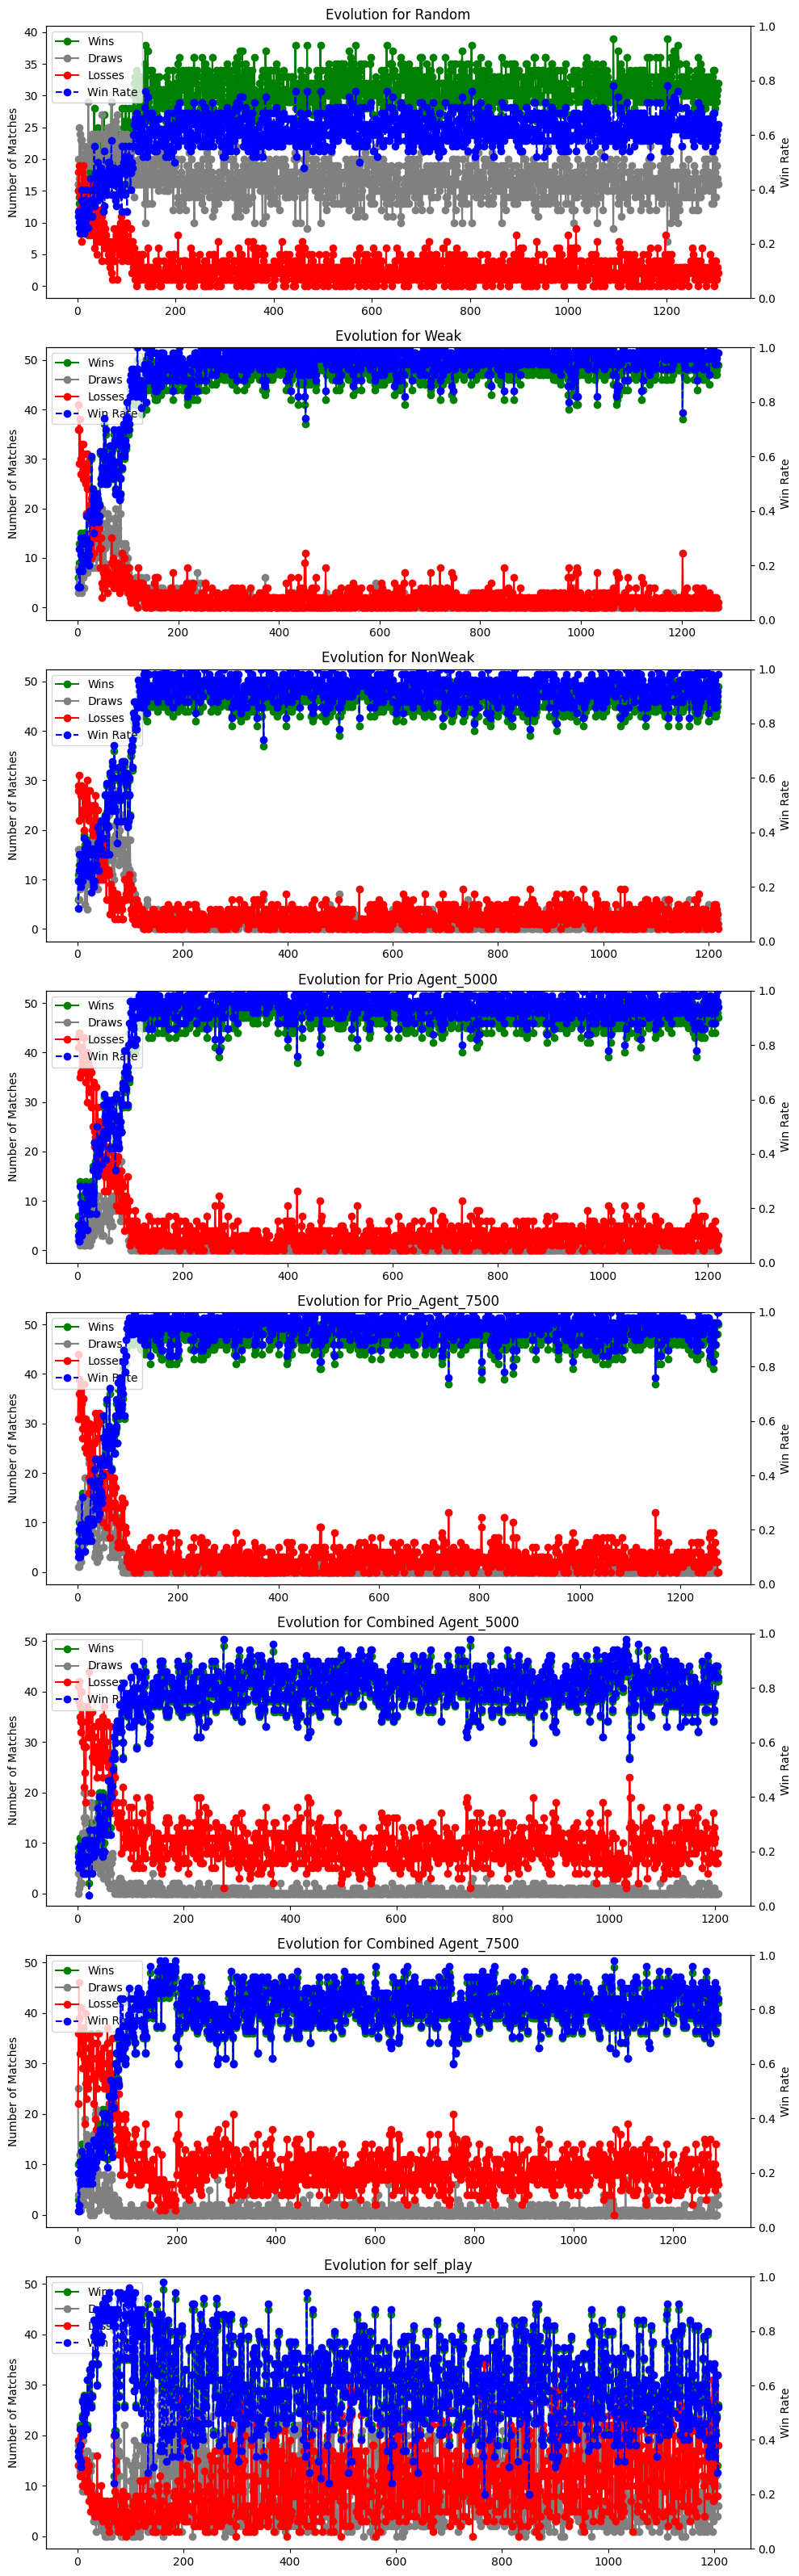

In [56]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)

In [57]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  

    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: 9.055159132530916
Test Episode 2, Total Reward: 9.607817548172818
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: 1.0541545658209852
Test Episode 5, Total Reward: 0.0
Test Episode 6, Total Reward: 1.6332604671755568
Test Episode 7, Total Reward: 0.0
Test Episode 8, Total Reward: 9.357038151295004
Test Episode 9, Total Reward: 0.0
Test Episode 10, Total Reward: -12.926029435449047
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_random_vs_prio_agent.png


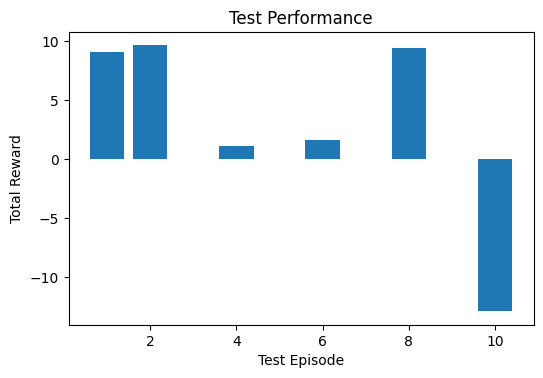

In [58]:
test_agent()

Test Episode 1, Total Reward: 9.715734460707859
Test Episode 2, Total Reward: 9.409843444823302
Test Episode 3, Total Reward: 9.304730262739563
Test Episode 4, Total Reward: 9.556864621320596
Test Episode 5, Total Reward: -11.309781308761163
Test Episode 6, Total Reward: 6.93111111083487
Test Episode 7, Total Reward: 9.448169649642047
Test Episode 8, Total Reward: 9.263518259392336
Test Episode 9, Total Reward: 9.324068120021357
Test Episode 10, Total Reward: 9.25827732712291
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_weak_vs_prio_agent.png


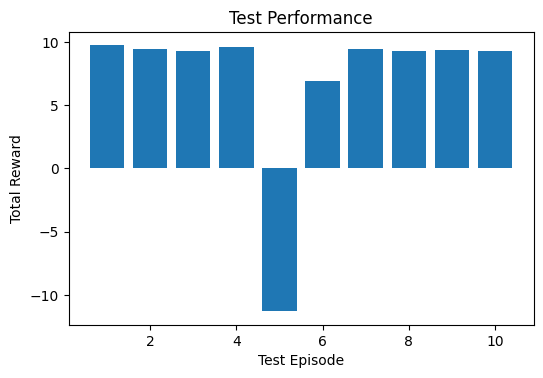

In [59]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")



Test Episode 1, Total Reward: 8.551910047055333
Test Episode 2, Total Reward: -11.981965173769698
Test Episode 3, Total Reward: 8.744335156504174
Test Episode 4, Total Reward: 9.361313394593287
Test Episode 5, Total Reward: 8.741756496707087
Test Episode 6, Total Reward: 7.24054263805493
Test Episode 7, Total Reward: 8.744115437567384
Test Episode 8, Total Reward: -8.260077786554593
Test Episode 9, Total Reward: 8.418148897840934
Test Episode 10, Total Reward: 8.908670158722373
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_non_weak_vs_prio_agent.png


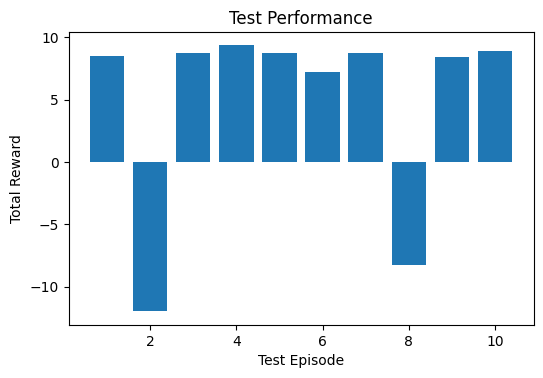

In [60]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

Network loaded from ../weights/prio_agent_self_play_17_2_25/weights/episode_1500.pth
Test Episode 1, Total Reward: 8.998779600683914
Test Episode 2, Total Reward: 9.53870730051188
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: 6.191422770177317
Test Episode 5, Total Reward: -7.824423788377493
Test Episode 6, Total Reward: 4.944079639508536
Test Episode 7, Total Reward: 9.487945928093076
Test Episode 8, Total Reward: 4.617047620454822
Test Episode 9, Total Reward: -10.804123442694452
Test Episode 10, Total Reward: 8.915273337533641
Plot saved at ../weights/prio_agent_self_play_17_2_25/stats/plots/test_results_selfplay.png


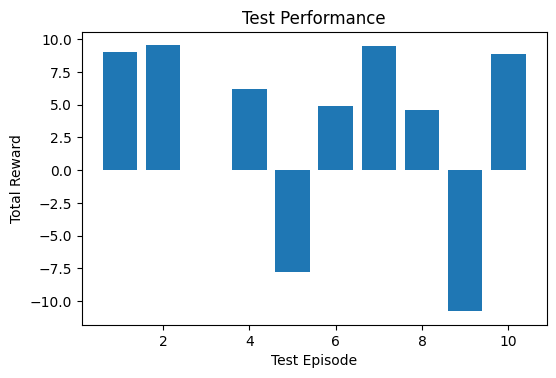

In [61]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.perform_greedy_action(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")